In [1]:
import win_probability
import pandas as pd
pd.set_option('mode.chained_assignment', None)

In [2]:
params_df = win_probability.fit('ODIs', 50, 1.0)
params_df.to_csv('ODIs/parameters1.csv', index=False)

In [3]:
from glob import glob
import re
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

location = "ODIs"
ball_by_ball_match_string= "{0}/data/ball_by_ball/([0-9]*).csv".format(location)

ball_by_ball_file_names = glob('{0}/data/ball_by_ball/*.csv'.format(location))
game_ids = set(map(lambda x: re.match(ball_by_ball_match_string, x).groups()[0],
                                                  ball_by_ball_file_names))
params_df = pd.read_csv('ODIs/parameters1.csv')
params_1_df = params_df[params_df.innings == 1] 
params_2_df = params_df[params_df.innings == 2]

In [4]:
def process_single_game(game_id):
    bb = pd.read_csv('ODIs/data/ball_by_ball/{0}.csv'.format(game_id))
    md = pd.read_csv('ODIs/data/match_summary/{0}.csv'.format(game_id))
    if not md.Reduced_Over.values[0]:
        fid, sid = win_probability.predict_game(bb, 50, params_1_df, params_2_df)
        fig = win_probability.plot_game(fid, sid, md, 50)
        return fid, sid, fig
    return None, None, None

/Users/kaushik/win_probability/win_probability.py:85: UserWarning: Empty data frame
  warnings.warn('Empty data frame')


1158068
1089781
810831


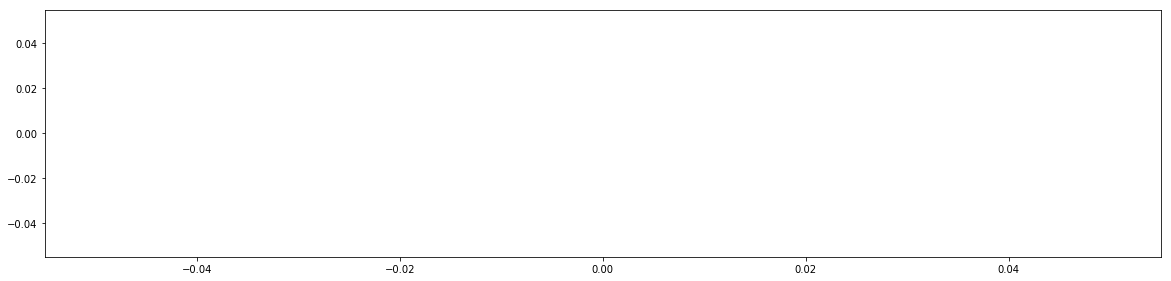

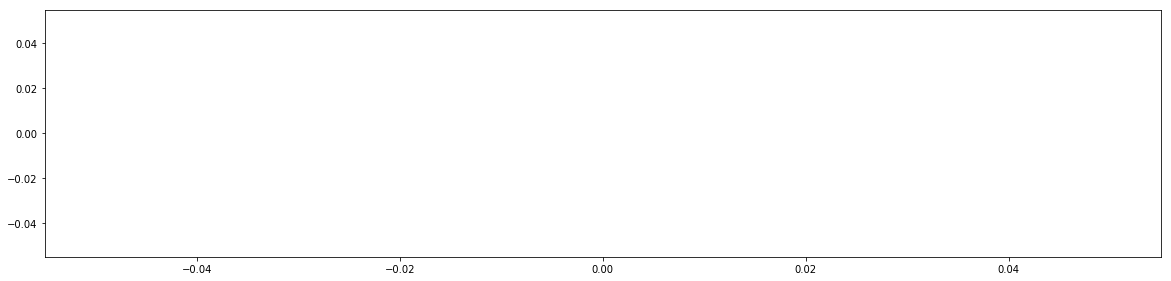

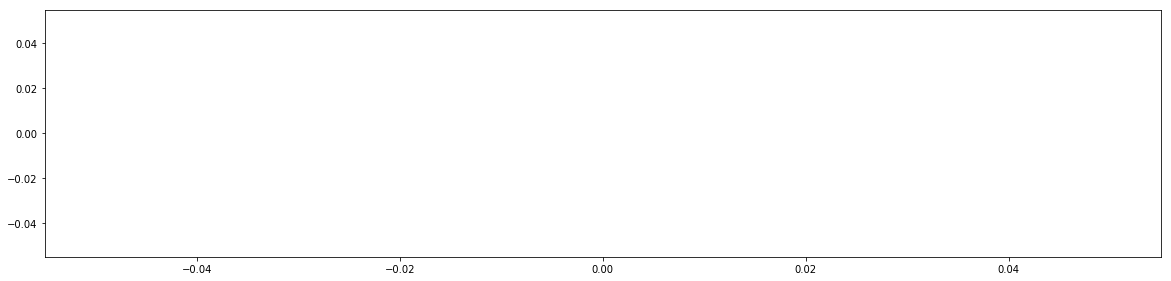

In [5]:
pdf = PdfPages('ODIs/win_probability_graphs_1.pdf')
first_inningses = []
second_inningses = []
for game_id in game_ids:
    try:
        fid, sid , fig = process_single_game(game_id)
        if fid is not None:
            pdf.savefig(fig)
            plt.close()
            fid['game_id'] = game_id
            sid['game_id'] = game_id
            first_inningses.append(fid)
            second_inningses.append(sid)
    except:
        print(game_id)
        continue

pdf.close()
pd.concat(first_inningses).to_csv('ODIs/win_probability_1st_innings_1.csv', index=False)
pd.concat(second_inningses).to_csv('ODIs/win_probability_2nd_innings_1.csv', index=False)


In [6]:
params_df = pd.read_csv('ODIs/parameters.csv')
params_1_df = params_df[params_df.innings == 1] 
params_2_df = params_df[params_df.innings == 2]

gen = win_probability.win_probability_matrix_generator(params_1_df, params_2_df, 50)
def write_first_innnings(prediction):
    over = prediction.Over
    wicket = prediction.Wickets
    run = prediction.Runs
    wp = prediction.win_probability
    score = prediction.score
    lo = prediction.score_lo
    hi = prediction.score_hi
    
    return "\t".join([str(x) for x in [over,
                                       wicket,
                                       run,
                                       wp,
                                       score,
                                       lo,
                                       hi]])+"\n"

def write_second_innings(prediction):
    over = 50 - prediction.Over
    wicket = 10 - prediction.Wickets
    run = prediction.Runs
    wp = 1 - prediction.win_probability
    score = prediction.score
    lo = prediction.score_lo
    hi = prediction.score_hi
    
    return "\t".join([str(x) for x in [over,
                                       wicket,
                                       run,
                                       wp,
                                       score,
                                       lo,
                                       hi]])+"\n"
f1 = open('ODIs/probs_i1_from_model_1.txt', 'w')
f2 = open('ODIs/probs_i2_from_model_1.txt', 'w')

for p1, p2 in gen:
    f1.write(write_first_innnings(p1))
    f2.write(write_second_innings(p2))
f1.close()
f2.close()